<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Options</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter-data" data-toc-modified-id="Filter-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Filter data</a></span></li><li><span><a href="#Filter-holdings" data-toc-modified-id="Filter-holdings-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Filter holdings</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Other functions</a></span></li><li><span><a href="#Cluster-with-Spectral-Clustering" data-toc-modified-id="Cluster-with-Spectral-Clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cluster with Spectral Clustering</a></span></li></ul></div>

# Clustering

## Description

- Cluster funds using k-means

## Setup

In [2]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import Normalizer

from minisom import MiniSom

### Options

In [3]:
year             = 2017
style_class      = 'lipper_class' # Choose lipper_class, style_class or cap_class

### Load Data

In [4]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

### Filter data 

In [5]:
row_info_f = row_info.query('year == @year')

begin_date = row_info_f.iloc[0,:]['report_dt']
end_date = begin_date + pd.DateOffset(years=1,months=1,days = 5)
row_info_f.reset_index(drop = True, inplace=True)

# Filter returns
crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
returns_f = returns.copy()
query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
returns_f = returns_f.query(query)

# Change return of month for which holdings apply to 0
mask = returns_f['report_dt'] == begin_date
returns_f.loc[mask,'mret'] = 0

# Filter holdings accordingly and delet all empty columns
holdings_f = holdings[row_info_f['row']]
col_sums = pd.DataFrame(holdings_f.sum(0).T).values 
mask = (col_sums != 0).flatten()
holdings_f = holdings_f[:,mask]

print('Numer of unique funds:           {:10,d}'.format(row_info_f.shape[0]))
print('Numer of unique securities:      {:10,d}'.format(holdings_f.shape[1]))
print('Begin date:                      {}'.format(begin_date.date()))
print('End date:                        {}'.format(end_date.date()))

Numer of unique funds:                1,819
Numer of unique securities:           5,294
Begin date:                      2017-06-30
End date:                        2018-08-04


### Filter holdings

In [6]:
# Generate sparse holdings matrix with boolean values instead of more precise percent_tna values
holdings_b = sparse.csr_matrix(holdings_f, copy=True)
holdings_b.data = np.ones(len(holdings.data))

In [7]:
# Each security has to appear at least x times stocks
sum_sec_boolean = holdings_b.toarray().sum(0)
col_mask = (sum_sec_boolean >= 2).flatten()

holdings_f = holdings_f.tocsc()
holdings_f = holdings_f[:,col_mask]
holdings_f = holdings_f.tocsr()

np.sum(col_mask)

4874

## Preprocessing

In [8]:
transformer = Normalizer().fit(holdings_f)
holdings_ft = transformer.transform(holdings_f)

## Other functions

In [9]:
def plot_cluster(row_info_f,style):
    sns.set()
    sns.set_style("white")
    data = round(
        pd.crosstab(
            row_info_f[style],row_info_f['cluster'], 
            margins = True, normalize = 'columns') * 100, 2).T

    ax = data.plot(kind='bar', 
                 stacked=True, 
                 figsize=(15,2))

    #ax.legend(bbox_to_anchor=(1, 1))
    ax.legend().remove()
    label_list = data.columns.values.astype(str).repeat(data.shape[0])
    rects = ax.patches

    # For each bar: Place a label
    for i, rect in enumerate(rects):
        if rect.get_height() > 10:
            # Get X and Y placement of label from rect.
            x_value = rect.get_x() + rect.get_width() / 2
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 0


            # Use X value as label and format number with one decimal place
            label = "{}".format(label_list[i])

            # Create annotation
            plt.annotate(
                label,                        # Use `label` as label
                (x_value, y_value),           # Place label at end of the bar
                xytext = (space, 0),          # Horizontally shift label by `space`
                textcoords = 'offset points', # Interpret `xytext` as offset in points
                va='center',                  # Vertically center label
                ha='center',
                color = 'white',
                size = 12)                  # Horizontally align label 
    plt.show()

## Cluster with Spectral Clustering

In [10]:
# Rule of thumb no of neuros:
a = 5 * np.sqrt(row_info_f.shape[0])
np.sqrt(a)

14.603036708895901

In [11]:
from minisom import MiniSom

### Initialization and training ###
som = MiniSom(x = 20,
              y = 20,
              input_len = holdings_f.shape[1],
#              neighborhood_function = 'triangle',
              sigma = 3.0,
              learning_rate = 0.5)

In [12]:
data = holdings_ft.toarray()
som.random_weights_init(data)
print("Training...")

som.train_random(data, 10000, verbose = True) # training with 100 iterations
print("\n...ready!")

Training...
 [ 10000 / 10000 ] 100% - 47.69 it/s - 0:00:00 left  - quantization error: 0.8487713119442022

...ready!


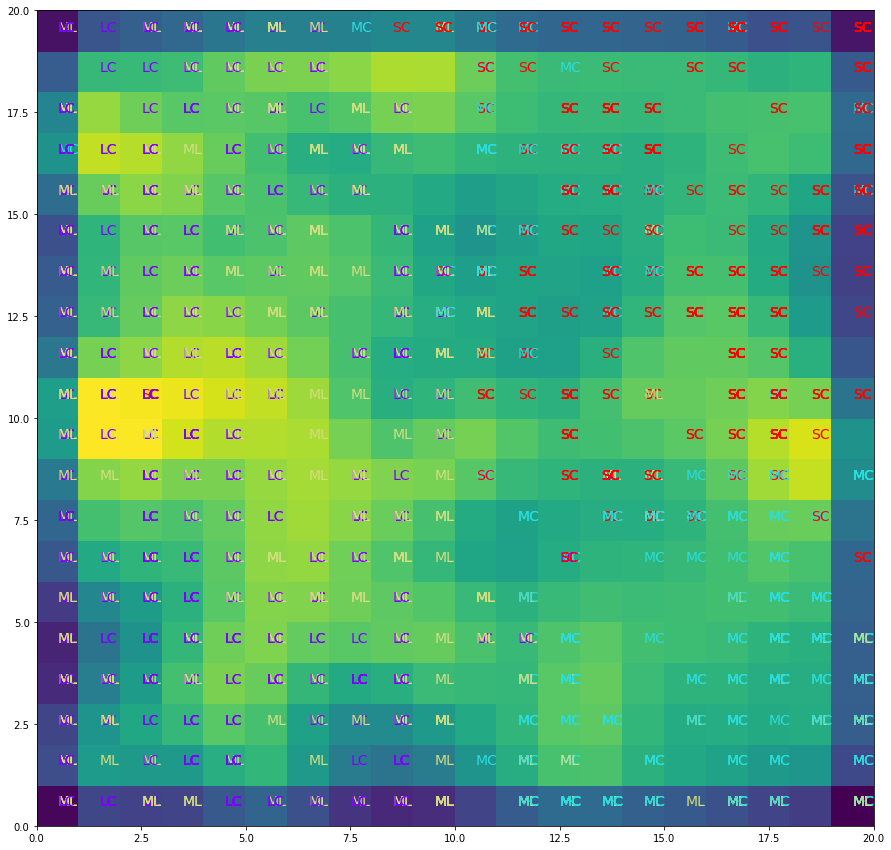

In [13]:
label = row_info_f['cap_class'].values
encoder = LabelEncoder()
num = encoder.fit_transform(label)

cmap = cm.rainbow(np.linspace(0.0, 1.0, np.max(num) + 1))

plt.figure(figsize=(15, 15))
plt.pcolor(som.distance_map())
wmap = {}
im = 0
for data, label, num in zip(data, label, num):  # scatterplot
    w = som.winner(data)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(label),
              color = cmap[num], fontdict={'size': 14})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
#plt.savefig('resulting_images/som_digts.png')
plt.show()

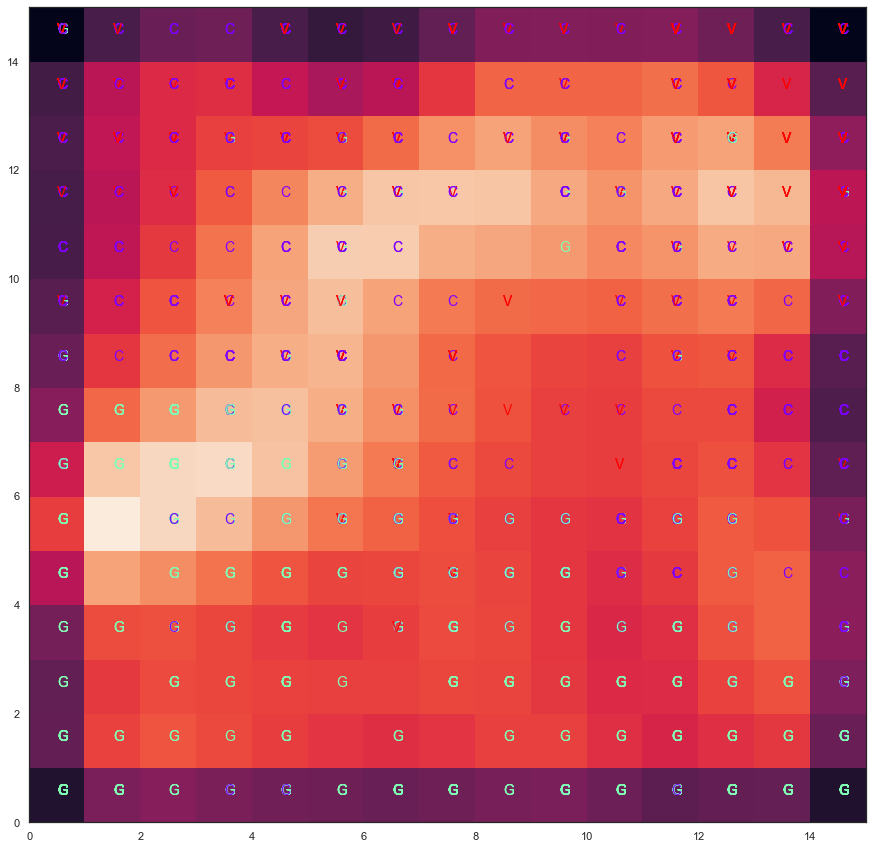

In [22]:
data = holdings_ft.toarray()

label = row_info_f['style_class'].values
encoder = LabelEncoder()
num = encoder.fit_transform(label)

cmap = cm.rainbow(np.linspace(0.0, 1.0, np.max(num) + 1))

plt.figure(figsize=(15, 15))
plt.pcolor(som.distance_map())
data = holdings_ft.toarray()

wmap = {}
im = 0
for data, label, num in zip(data, label, num):  # scatterplot
    w = som.winner(data)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(label),
              color = cmap[num], fontdict={'size': 14})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
#plt.savefig('resulting_images/som_digts.png')
plt.show()

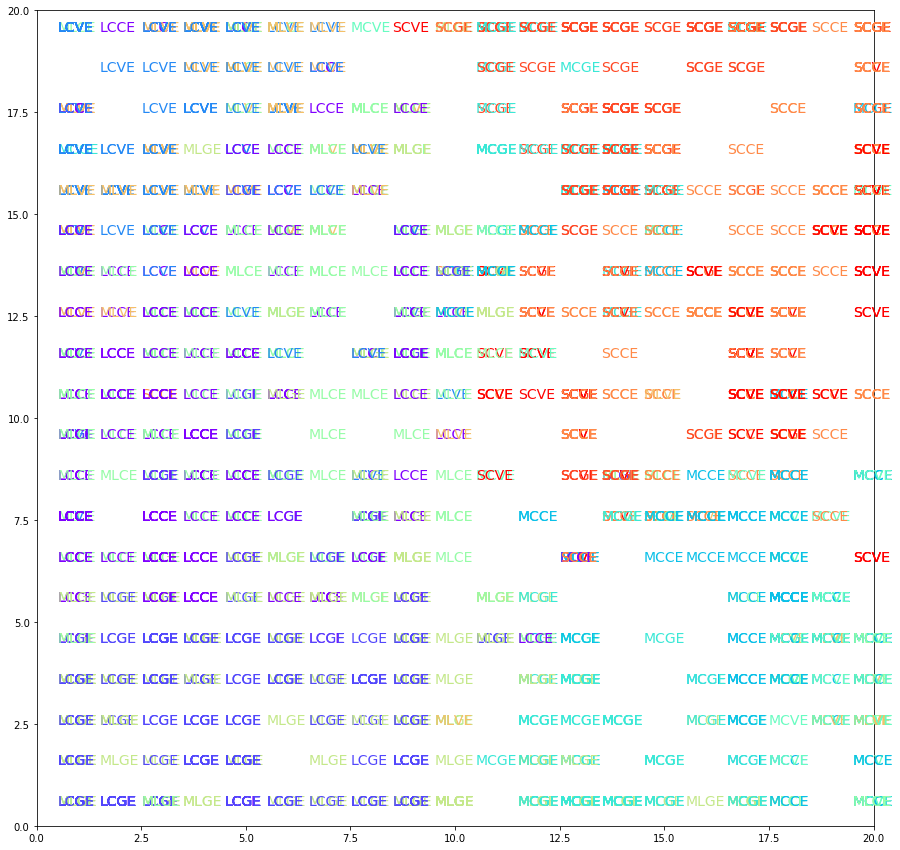

In [15]:
label = row_info_f['lipper_class'].values
encoder = LabelEncoder()
num = encoder.fit_transform(label)
data = holdings_ft.toarray()

cmap = cm.rainbow(np.linspace(0.0, 1.0, np.max(num) + 1))

plt.figure(figsize=(15, 15))
wmap = {}
im = 0
for data, label, num in zip(data, label, num):  # scatterplot
    w = som.winner(data)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(label),
              color = cmap[num], fontdict={'size': 14})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
#plt.savefig('resulting_images/som_digts.png')
plt.show()

In [16]:
from minisom import MiniSom

### Initialization and training ###
som = MiniSom(x = 15,
              y = 15,
              input_len = holdings_f.shape[1],
#              neighborhood_function = 'triangle',
              sigma = 3.0,
              learning_rate = 0.5)

In [17]:
data = holdings_ft.toarray()
som.random_weights_init(data)
print("Training...")

som.train_random(data, 10000, verbose = True) # training with 100 iterations
print("\n...ready!")

Training...
 [ 10000 / 10000 ] 100% - 105.27 it/s - 0:00:00 left  - quantization error: 0.8627171139617982

...ready!


In [18]:
data = holdings_ft.toarray()
som_quantized = som.quantization(data)

In [19]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 6,
                verbose = True,
                n_init = 10, # Number of runs
                n_jobs= -1,
                random_state = 1
               ).fit(som_quantized)

row_info_f = row_info_f.assign(cluster = kmeans.labels_)

Start kMeans...


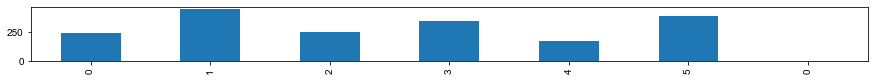

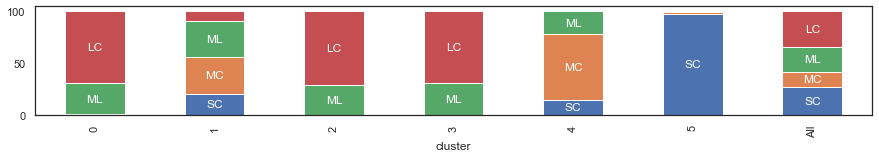

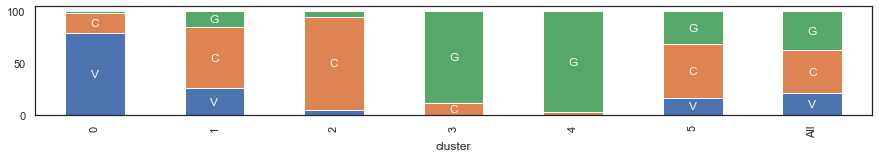

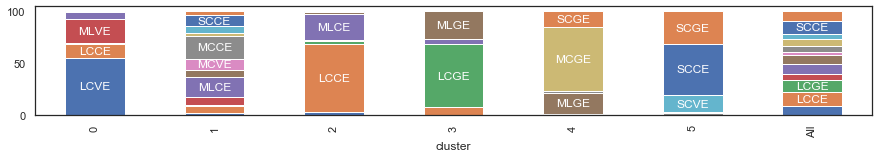

In [20]:
data = row_info_f['cluster'].value_counts(sort=False).append(to_append = pd.Series([0]))
data.plot(kind='bar', figsize = (15,1))

print('')
plot_cluster(row_info_f,'cap_class')
plot_cluster(row_info_f,'style_class')
plot_cluster(row_info_f,'lipper_class')